# CAPSTONE PROJECT: Analysis of Camden County, NJ
APPLIED DATA SCIENCE CAPSTONE<br>
_David Mislan_

## FRONT MATTER

### The Business Problem

A group of investors are exploring the possibility of opening an Izakaya in Philadelphia's eastern suburbs. While they know the characteristics of the ideal town or neighborhood, they are having difficulty identifying the optimal location.

### Background 

An izakaya is a type of Japanese restaurant that is often compared to a pub. Both are convivial places for people to get together after work, have a drink, and socialize. The food, however, is quite different. Some izakaya serve sushi, but they are best known for grilled meats, shellfish, and homestyle snacks served in small portions. Izakaya are usually in smaller venues, where patrons stand two or three rows back from a service counter with limited seating. Some upscale izakaya will have a second room with tatami (floor mat) seating, where larger groups can congregate around short tables. This type of restaurant is seldom found in the United States, but a group of investors are betting that it would strongly appeal to young, white collar professionals.

Due to its proximity to Philadelphia and because of local tax incentives, the investors wish to establish their new business in Camden County, New Jersey.  This area consists of mostly suburban commuter towns known locally as bedroom communities. As of 2020, an estimated 508,000 people reside in Camden County. Some of the more significant towns and boroughs in Camden County are on the PATCO Hi-Speedline, a subway / elevated train that connects residents to Philadelphia’s center city in 10-30 minutes.

### The Client

The investors have developed a profile of their modal customer: 21-35 years old; college educated; likes Asian cuisines (e.g. Chinese, Korean, Japanese, Vietnamese, Indian); and goes out for drinks after work. They do not, however, have a more specific idea of where their new business should be. They agree that the izakaya should be in a location that (1) has a high concentration of restaurants with ethnic cuisines; (2) is close to the PATCO Hi-Speedline; and (3) has a bar scene. This is where an analysis of the towns of Camden County can be useful. 

### Data

Most of the data used to analyze the towns of Camden County will come from Foursquare’s Places API. Specifically, this analysis will collect and use information on Camden County restaurants; bars; and public transportation.

Additional data (mostly geodata) will be used as well. These data will be collected via a Python-based geocoding client called Geopy. 

#### _Essential Features to Analyze_

1. Zip Code
2. Geocode (latlong)
3. Asian Restaurants
4. Bars
5. Train Stations
6. Public Transportation

#### _How data will be used_ 

This project will proceed in six steps:

1.	Scrape the web for a list of Camden County ZIP codes and ZIP-specific descriptors.
2.	Find geographic coordinates for each ZIP and plot them on a county map.
3.	For each ZIP code, leverage Foursquare’s Places API to assemble venue data organized by category.
4.	Explore and visualize key features to include in a cluster analysis.
5.  Use clustering techniques to assess the suitability of each location for the new business.
6.  Find three viable ZIP codes and make a recommendation to the investors. 

Before I began, I imported all of the libraries I would need to conduct my analysis.

In [1]:
#import libraries for analysis
import pandas as pd #for making dataframes
import numpy as np #for analysis
from sklearn.cluster import KMeans #KNN analysis 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# import libraries for data vizualization
import matplotlib as mpl
import seaborn as sns #makes plots and other output pretty

#import libraries for webscraping
import requests #use for API calls
from bs4 import BeautifulSoup #scrapes data from HTML files
from pandas.io.json import json_normalize #transfers data in JSON file to a pandas df

#import libraries for geocoding
from geopy.geocoders import Nominatim #finds locations for geocoding

#import libraries for making maps
import folium #visualize data with maps
import matplotlib.cm #for making a color map with geo-specific data
import matplotlib.colors #for making nice colors
from IPython.display import Image #displays an image from a file in a Jupyter nb
from IPython.core.display import HTML #displays HTML image

print("libraries imported")

libraries imported


### STEP ONE

The first step was to assemble some basic information on Camden County and its municipalities. Since each municipality has its own ZIP code, the best way to proceed was to collect ZIP code data.

First, I found a web page that contained all of the desired ZIP code information. Then, I scraped the table and converted the JSON file to a pandas dataframe and named it _zip_data_. After removing the multiindexing and doing some basic data cleaning, I was ready to proceed. 

In [2]:
url = "https://www.zipdatamaps.com/camden-nj-county-zipcodes" # defines URL for website to scrape
data = requests.get(url).text # scrapes the webpage, soup to nuts
soup = BeautifulSoup(data, "html5lib") # creates a BS object, this is the new object

tables = soup.find_all("table") #extracts tables from object, creates new object with just tables
for index, table in enumerate(tables): #loops through each table in object
    if ("Non-Unique" in str(table)): # instructions to search object for desired table
        table_index = index #saves the number of the desired table

In [3]:
zip_data = pd.read_html(str(tables[table_index]), flavor="bs4")[0]

In [4]:
zip_data.head() # visually inspect the first five rows for formatting issues
zip_data.dropna(axis=0, inplace=True) # drops the rows that are duplicates and missing values
zip_data.reset_index(drop=True, inplace=True) # resets the index
print(zip_data.columns) # retrieve column names
zip_data.columns = zip_data.columns.droplevel() #removes multiindexing column name
print("multiindexing removed")
zip_data.dtypes # checks data types
zip_data = zip_data.astype({"ZIP Code": "int64",
                 "ZIP Code Name": "object",
                 "Population": "int64",
                 "ZIP Type": "object"}) #change data types, remove decimal from zip code
zip_data = zip_data.astype({"ZIP Code": "object"}) #change zip code to a string

MultiIndex([('List of All Zipcodes in Camden County, New Jersey', ...),
            ('List of All Zipcodes in Camden County, New Jersey', ...),
            ('List of All Zipcodes in Camden County, New Jersey', ...),
            ('List of All Zipcodes in Camden County, New Jersey', ...)],
           )
multiindexing removed


In [5]:
zip_data["ZIP Code"] = "0" + zip_data["ZIP Code"].astype(str) #restore first element (0), a constant

In [6]:
for index, row in zip_data.iterrows(): # remove ZIP codes that do not represent geographic entities (PO Box)
    if (row[3] == "PO Box"):
        zip_data.drop(index, inplace=True)
    else:
        continue

zip_data.drop(columns=["ZIP Type"]) # drop ZIP Type column and visually inspect

,ZIP Code,ZIP Code Name,Population
0,08002,Cherry Hill,22274
1,08003,Cherry Hill,30629
2,08004,Atco,12350
3,08007,Barrington,5250
4,08009,Berlin,12854
5,08012,Blackwood,38992
6,08021,Clementon,44833
7,08026,Gibbsboro,2274
8,08029,Glendora,4784
9,08030,Gloucester City,13410


### STEP TWO

My next task was to develop a map of Camden County that plotted the location of each ZIP code's geographic center. To do this, I first used Geopy to aquire latitude and longitude data for each ZIP code. Then, I added this geodata to _zip_data_. Once I had all of the ZIP code centroids, I was able to create a simple Camden County map. As you can see, most of the ZIP codes are in close proximity to Philadelphia.

In [7]:
latitude_list = [] # create an empty list to populate with latitudes of zip codes
longitude_list = [] # create an empty list to populate with longitudes of zip codes

for i in zip_data["ZIP Code"]: #create a loop to find lat, long and populate lists
    address = "New Jersey "+i # concactenate _New Jersey_ with zip_code in order to get New Jersey lat, long
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitude_list.append(latitude)
    longitude_list.append(longitude)

zip_data["Latitude"] = latitude_list #add latitudes to dataframe
zip_data["Longitude"] = longitude_list #add longitudes to dataframe

zip_data

,ZIP Code,ZIP Code Name,Population,ZIP Type,Latitude,Longitude
0,08002,Cherry Hill,22274,Non-Unique,39.916258,-75.021428
1,08003,Cherry Hill,30629,Non-Unique,39.883812,-74.980346
2,08004,Atco,12350,Non-Unique,39.765233,-74.877511
3,08007,Barrington,5250,Non-Unique,39.866853,-75.055078
4,08009,Berlin,12854,Non-Unique,39.775616,-74.938829
5,08012,Blackwood,38992,Non-Unique,39.758867,-75.055420
6,08021,Clementon,44833,Non-Unique,39.802230,-75.019991
7,08026,Gibbsboro,2274,Non-Unique,39.836474,-74.971014
8,08029,Glendora,4784,Non-Unique,39.841182,-75.066353
9,08030,Gloucester City,13410,Non-Unique,39.890511,-75.116426


In [8]:
# create map
# find geographic center of camden county for map
address = "Camden County, New Jersey"
geolocator = Nominatim(user_agent="camden_county_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#instantiate map of camden county
camden_county_map = folium.Map(location=[latitude, longitude], zoom_start=10)

#add markers for zip codes
for lat, long, zipcode, city in zip(zip_data["Latitude"], 
                                    zip_data["Longitude"], 
                                    zip_data["ZIP Code"], 
                                    zip_data["ZIP Code Name"]):
    label = "{}, {}".format(zipcode, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, long], 
                        radius=5,
                       popup=label,
                       color="blue",
                       fill=True,
                       fill_color="#3186cc",
                       fill_opacity=0.7,
                       parse_html=False).add_to(camden_county_map)

camden_county_map

### STEP THREE

My next step was to collect venue data on each ZIP code. In addition to the essential features listed in my research design (Asian restaurants, bars, and train stations), I also collected information on each ZIP code's Japanese restaurants, ramen restaurants, sushi restaurants, and nightlife spots. I used FourSquare's Places API to collect the data. I did this by sending looping through ZIP codes and sending API calls for each venue category (e.g., Asian restaurant.) Then, I counted the number of venues and added the total as a new feature in the _zip_data_ dataframe. The final result was an updated _zip_data_ that included all of the data necessary to compare the each ZIP code's suitability for a new izakaya.

In [9]:
# load FourSquare API credentials and search parameters

CLIENT_ID = "xxxxx"
CLIENT_SECRET = "xxxxx" 
ACCESS_TOKEN = "xxxxx"
VERSION = "20180604"
LIMIT = 50
RADIUS = 5000

In [10]:
# load venue categories and their ids as a dictionary

categories = {"Train Station": "4bf58dd8d48988d129951735", 
              "Bar": "4bf58dd8d48988d116941735", 
              "Nightlife Spot": "4d4b7105d754a06376d81259", 
              "Asian Restaurant": "4bf58dd8d48988d142941735", 
              "Japanese Restaurant": "4bf58dd8d48988d111941735", 
              "Ramen Restaurant": "55a59bace4b013909087cb24", 
              "Sushi Restaurant": "4bf58dd8d48988d1d2941735"}

In [11]:
# make API calls for each venue category for each ZIP code
# count the number of venues per category for each ZIP code

zip_code_list = []
zip_name_list = []
train_count_list = []
bar_count_list = []
nightlife_count_list = []
asian_count_list = []
japanese_count_list = []
ramen_count_list = []
sushi_count_list = []

for zipcode, zipname, lat, lng in zip(zip_data["ZIP Code"], 
                                      zip_data["ZIP Code Name"], 
                                      zip_data["Latitude"], 
                                      zip_data["Longitude"]): 
    zip_code = zipcode # assigns zipcode for current search
    zip_code_list.append(zip_code)
    zip_name = zipname
    zip_name_list.append(zip_name)
    latitude = lat # assigns latitude for current search
    longitude = lng # assigns longitude for current search
    for key, value in categories.items(): #loop through each category and write a query for each category
        category_name = key
        category_id = value   
        url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            ACCESS_TOKEN, 
            VERSION, 
            category_id, 
            RADIUS, 
            LIMIT) 
        results = requests.get(url).json() # calls API and retrieves a JSON file 
        filtered_results = results["response"]["venues"] # filters out everything except venue data
        temp_df = pd.json_normalize(filtered_results) # converts JSON file to pandas dff
        try:
            for index, row in temp_df.iterrows(): # loop through df and drop results not in current zipcode
                if row["location.postalCode"] == zip_code:
                    continue
                else:
                    temp_df.drop([index], inplace=True)
        except KeyError:
            print(f"There was a problem with {zip_name}, {zip_code}, {category_name}.")
        count = len(temp_df)
        print(f"There are {count} {category_name}(s)in ZIP code {zip_name}, {zip_code}.")
        if (category_id == "4bf58dd8d48988d129951735"):
            train_count_list.append(count)
        elif (category_id == "4bf58dd8d48988d116941735"):
            bar_count_list.append(count)
        elif (category_id == "4d4b7105d754a06376d81259"):
            nightlife_count_list.append(count)
        elif (category_id == "4bf58dd8d48988d142941735"):
            asian_count_list.append(count)
        elif (category_id == "4bf58dd8d48988d111941735"):
            japanese_count_list.append(count)
        elif (category_id == "55a59bace4b013909087cb24"):
            ramen_count_list.append(count)
        else:
            sushi_count_list.append(count)

There are 2 Train Station(s)in ZIP code Cherry Hill, 08002.
There are 5 Bar(s)in ZIP code Cherry Hill, 08002.
There are 7 Nightlife Spot(s)in ZIP code Cherry Hill, 08002.
There are 7 Asian Restaurant(s)in ZIP code Cherry Hill, 08002.
There are 7 Japanese Restaurant(s)in ZIP code Cherry Hill, 08002.
There are 0 Ramen Restaurant(s)in ZIP code Cherry Hill, 08002.
There are 3 Sushi Restaurant(s)in ZIP code Cherry Hill, 08002.
There are 1 Train Station(s)in ZIP code Cherry Hill, 08003.
There are 4 Bar(s)in ZIP code Cherry Hill, 08003.
There are 4 Nightlife Spot(s)in ZIP code Cherry Hill, 08003.
There are 12 Asian Restaurant(s)in ZIP code Cherry Hill, 08003.
There are 7 Japanese Restaurant(s)in ZIP code Cherry Hill, 08003.
There are 1 Ramen Restaurant(s)in ZIP code Cherry Hill, 08003.
There are 3 Sushi Restaurant(s)in ZIP code Cherry Hill, 08003.
There are 1 Train Station(s)in ZIP code Atco, 08004.
There are 8 Bar(s)in ZIP code Atco, 08004.
There are 11 Nightlife Spot(s)in ZIP code Atco, 080

There are 0 Ramen Restaurant(s)in ZIP code Runnemede, 08078.
There are 1 Sushi Restaurant(s)in ZIP code Runnemede, 08078.
There are 1 Train Station(s)in ZIP code Sewell, 08080.
There are 10 Bar(s)in ZIP code Sewell, 08080.
There are 9 Nightlife Spot(s)in ZIP code Sewell, 08080.
There are 13 Asian Restaurant(s)in ZIP code Sewell, 08080.
There are 5 Japanese Restaurant(s)in ZIP code Sewell, 08080.
There are 0 Ramen Restaurant(s)in ZIP code Sewell, 08080.
There are 2 Sushi Restaurant(s)in ZIP code Sewell, 08080.
There are 0 Train Station(s)in ZIP code Sicklerville, 08081.
There are 5 Bar(s)in ZIP code Sicklerville, 08081.
There are 10 Nightlife Spot(s)in ZIP code Sicklerville, 08081.
There are 13 Asian Restaurant(s)in ZIP code Sicklerville, 08081.
There are 4 Japanese Restaurant(s)in ZIP code Sicklerville, 08081.
There are 0 Ramen Restaurant(s)in ZIP code Sicklerville, 08081.
There are 1 Sushi Restaurant(s)in ZIP code Sicklerville, 08081.
There are 0 Train Station(s)in ZIP code Somerdale,

In [36]:
# add counts to zip_data as new variables

zip_data["Train"] = train_count_list
zip_data["Bars"] = bar_count_list
zip_data["Nightlife"] = nightlife_count_list
zip_data["Asian"] = asian_count_list
zip_data["Japanese"] = japanese_count_list
zip_data["Ramen"] = ramen_count_list
zip_data["Sushi"] = sushi_count_list

zip_data # visually inspect the complete dataframe

,ZIP Code,ZIP Code Name,Population,ZIP Type,Latitude,Longitude,Train,Bars,Nightlife,Asian,Japanese,Ramen,Sushi,Asian/1000pop,Cluster
0,08002,Cherry Hill,22274,Non-Unique,39.916258,-75.021428,2,5,7,7,7,0,3,0.314268,2
1,08003,Cherry Hill,30629,Non-Unique,39.883812,-74.980346,1,4,4,12,7,1,3,0.391786,2
2,08004,Atco,12350,Non-Unique,39.765233,-74.877511,1,8,11,1,0,0,0,0.080972,1
3,08007,Barrington,5250,Non-Unique,39.866853,-75.055078,0,1,1,1,1,0,1,0.190476,3
4,08009,Berlin,12854,Non-Unique,39.775616,-74.938829,0,6,10,7,1,0,1,0.544578,0
5,08012,Blackwood,38992,Non-Unique,39.758867,-75.055420,1,8,11,11,2,0,1,0.282109,1
6,08021,Clementon,44833,Non-Unique,39.802230,-75.019991,1,15,6,9,1,0,0,0.200745,1
7,08026,Gibbsboro,2274,Non-Unique,39.836474,-74.971014,0,3,1,1,0,0,0,0.439754,0
8,08029,Glendora,4784,Non-Unique,39.841182,-75.066353,0,0,2,1,0,0,0,0.209030,3
9,08030,Gloucester City,13410,Non-Unique,39.890511,-75.116426,0,4,1,0,0,0,0,0.000000,3


In [13]:
# export zip_data as a csv file for safe keeping

path = r"C:\Users\david\OneDrive\Desktop\pythong\zip_data.csv"
zip_data.to_csv(path)

### STEP FOUR

My intent was to use a cluster analysis to identify a group of ZIP codes that would be most suitable for a new izakaya. Before I conducted the analysis, however, I explored the data to identify key features. One conclusion, shown below, was that a simple count of Asian restaurants did not capute the desire for a *high concentration* of Asian restaurants. Thus, I used the population data recorded in step one to calculate a new feature, Asian restaurants per 1000 residents.

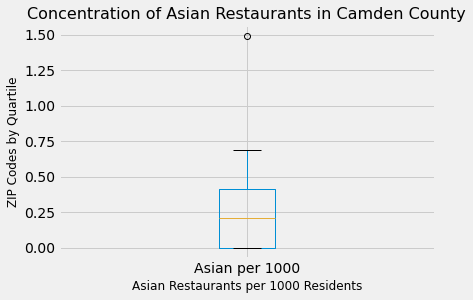

Berlin has a concentration of 0.545 for every 1000 people
Gibbsboro has a concentration of 0.44 for every 1000 people
Cherry Hill has a concentration of 0.606 for every 1000 people
Voorhees has a concentration of 0.481 for every 1000 people
Lawnside has a concentration of 0.688 for every 1000 people
Runnemede has a concentration of 0.477 for every 1000 people
Somerdale has a concentration of 0.529 for every 1000 people
West Berlin has a concentration of 1.493 for every 1000 people
Merchantville has a concentration of 0.446 for every 1000 people


In [76]:

mpl.style.use(["fivethirtyeight"]) # sets style

# identify ZIP codes with high concentration of Asian restaurants

asian = zip_data[["Asian"]]
population = zip_data[["Population"]]
asian_population = zip_data[["Population", "Asian"]]
asian_concentration_list = []
for index, row in asian_population.iterrows():
    asian_concentration = row[1]/(row[0]/1000)
    asian_concentration_list.append(asian_concentration)
zip_data["Asian per 1000"] = asian_concentration_list
zip_data.replace(np.inf, 0)
zip_data[["Asian per 1000"]].plot(kind="box") # go back to defining object to plot if this doesn't work
plt.title("Concentration of Asian Restaurants in Camden County", fontsize=16)
plt.xlabel("Asian Restaurants per 1000 Residents", fontsize=12)
plt.ylabel("ZIP Codes by Quartile", fontsize=12)
plt.show()

ident_tops = zip_data[["ZIP Code Name", "Asian per 1000"]]
top_quart_asian_conc = []
for index, row in ident_tops.iterrows():
    if row[1] >= 0.4:
        print(f"{row[0]} has a concentration of {round(row[1], 3)} for every 1000 people")
        top_quart_asian_conc.append(row[0])
    else:
        continue

As shown above, the concentration of Asian restaurants has a relatively wide variance. The middle 50%, however, is reliably between 0 and less than 0.50. The median concentration was less than 0.25. It's worth noting that all ZIP codes in the lowest quadrant has a score of 0, meaning they had no Asian restaurants.

Next, I explored the train stations feature. As it turned out, only twelve of the thirty-four ZIP codes analyzed had at least one train station.

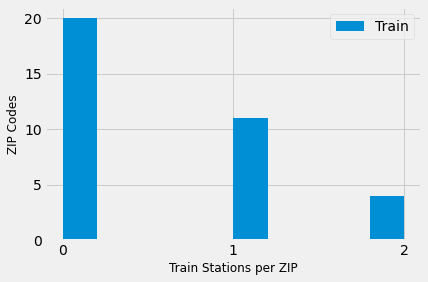

There are 12 cities in Camden County with train stations.


In [58]:
# identify and explore ZIP codes with train stations

zips_with_trains = []
for index, row in zip_data.iterrows():
    if row[6] != 0:
        zips_with_trains.append(row[1])
    else:
        continue
zips_with_trains = set(zips_with_trains)
zip_data[["Train"]].plot(kind="hist")
plt.xlabel("Train Stations per ZIP", fontsize=12)
plt.ylabel("ZIP Codes", fontsize=12)
plt.xticks(range(0, 3))
plt.show()
print(f"There are {len(zips_with_trains)} cities in Camden County with train stations.")

In [77]:
zips_with_trains

{'Atco',
 'Blackwood',
 'Camden',
 'Cherry Hill',
 'Clementon',
 'Collingswood',
 'Haddonfield',
 'Hammonton',
 'Pennsauken',
 'Runnemede',
 'Sewell',
 'Voorhees'}

Next, I turned to bars. Here, the distribution seemed to be a bit more normal. One outlier (Clementon had 15 bars) excepted, the plurality of ZIP codes had between one and five bars.

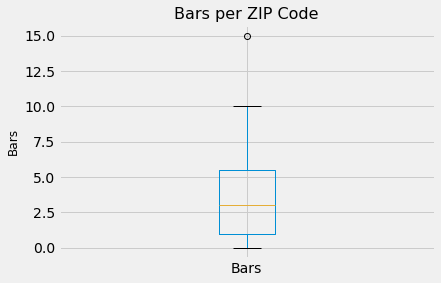

Atco 08004 has 8 bars.
Berlin 08009 has 6 bars.
Blackwood 08012 has 8 bars.
Clementon 08021 has 15 bars.
Voorhees 08043 has 8 bars.
Runnemede 08078 has 10 bars.
Sewell 08080 has 10 bars.
Collingswood 08108 has 8 bars.
Merchantville 08109 has 6 bars.


['Atco',
 'Berlin',
 'Blackwood',
 'Clementon',
 'Voorhees',
 'Runnemede',
 'Sewell',
 'Collingswood',
 'Merchantville']

In [63]:
# identify and explore ZIP codes with lively bar scenes

bars = zip_data[["Bars"]] 

bars.plot(kind="box")
plt.title("Bars per ZIP Code", fontsize=16)
plt.ylabel("Bars", fontsize=12)
plt.show()

top_quart_bars = []

for index, row in zip_data.iterrows():
    if (row[7] >= 6):
        print(f"{row[1]} {row[0]} has {row[7]} bars.")
        top_quart_bars.append(row[1])
    else:
        continue

top_quart_bars

### STEP FIVE

Before I conducted a cluster analysis, I took a moment to explore a couple of relationships. In short, I wanted to make sure that population was not correlating with other key features. This way, I could decide whether or not to include population in my model. In particular, I sought answers to two simple questions:

Do more populous ZIP codes tend to have more Asian restaurants?
Do more populous ZIP codes tend to have more bars?

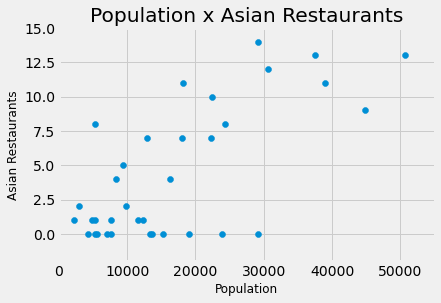


	Pearson's R is [0.70269744 1.        ]



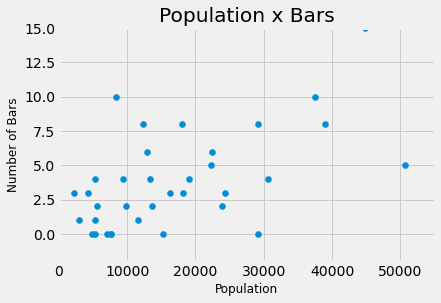


	Pearson's R is [0.56925493 1.        ]



In [64]:
# exlore relationships between variables

# do more populous zip codes tend to have more Asian restaurants?
plt.scatter(zip_data["Population"], zip_data["Asian"])
plt.title("Population x Asian Restaurants")
plt.xlabel("Population", fontsize=12)
plt.ylabel("Asian Restaurants", fontsize=12)
plt.xlim(0, 55000)
plt.ylim(-2, 15)
plt.show()

pop_v_asian = np.corrcoef(zip_data["Population"], zip_data["Asian"])

print(f"\n\tPearson's R is {pop_v_asian[1]}\n")

# do more populous zip codes tend to have more bars?

plt.scatter(zip_data["Population"], zip_data["Bars"])
plt.title("Population x Bars")
plt.xlabel("Population", fontsize=12)
plt.ylabel("Number of Bars", fontsize=12)
plt.xlim(0, 55000)
plt.ylim(-2, 15)
plt.show()

pop_v_bars = np.corrcoef(zip_data["Population"], zip_data["Bars"])

print(f"\n\tPearson's R is {pop_v_bars[1]}\n")

I concluded from the quick analysis above that there is a strong relationship (r = 0.703) between population and Asian restaurants. There was a weaker, yet still substantial, correlation (r = 0.569) between population and bars. Upon investigation, I learned the difference between the two was due to local ordinances. A handful of ZIP codes had local laws that prohibited the sale of alcohol.

Now, I was confident that I could build a valid model for cluster analysis using the following features:

**Asian restaurants per 1000 residents** <br>
**Bars** <br>
**Train stations**

I proceeded by creating a new dataframe that included the desired features and nominal variables used for identification (ZIP code, ZIP code name). Then, after normalizing the features, I instantiated the model with three clusters(*) and fit the data to it. 

(*) Ultimately, I would settle on a model with five clusters. See below.

In [94]:
# conduct a cluster (K means) analysis

working_df = zip_data[["ZIP Code",
                      "ZIP Code Name",
                      "Train",
                      "Bars",
                      "Asian/1000pop"]]

X = working_df.values[:,2:] # extracts variables as arrays
nrml_data = StandardScaler().fit_transform(X) # normalize features and save as nested array
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12) # instantiate
k_means.fit(nrml_data) # fit data to model

labels = k_means.labels_ # outputs cluster for each zip code
zip_data["Cluster"] = labels # add cluster designation to zip_data
zip_data

,ZIP Code,ZIP Code Name,Population,ZIP Type,Latitude,Longitude,Train,Bars,Nightlife,Asian,Japanese,Ramen,Sushi,Asian/1000pop,Cluster,Asian per 1000
0,08002,Cherry Hill,22274,Non-Unique,39.916258,-75.021428,2,5,7,7,7,0,3,0.314268,1,0.314268
1,08003,Cherry Hill,30629,Non-Unique,39.883812,-74.980346,1,4,4,12,7,1,3,0.391786,1,0.391786
2,08004,Atco,12350,Non-Unique,39.765233,-74.877511,1,8,11,1,0,0,0,0.080972,3,0.080972
3,08007,Barrington,5250,Non-Unique,39.866853,-75.055078,0,1,1,1,1,0,1,0.190476,2,0.190476
4,08009,Berlin,12854,Non-Unique,39.775616,-74.938829,0,6,10,7,1,0,1,0.544578,0,0.544578
5,08012,Blackwood,38992,Non-Unique,39.758867,-75.055420,1,8,11,11,2,0,1,0.282109,3,0.282109
6,08021,Clementon,44833,Non-Unique,39.802230,-75.019991,1,15,6,9,1,0,0,0.200745,3,0.200745
7,08026,Gibbsboro,2274,Non-Unique,39.836474,-74.971014,0,3,1,1,0,0,0,0.439754,0,0.439754
8,08029,Glendora,4784,Non-Unique,39.841182,-75.066353,0,0,2,1,0,0,0,0.209030,2,0.209030
9,08030,Gloucester City,13410,Non-Unique,39.890511,-75.116426,0,4,1,0,0,0,0,0.000000,2,0.000000


Then, I explored the results with a series of scatterplots and other basic evaluative techniques.

In [90]:
# explore the results

zip_data.groupby("Cluster").mean() # look at value of centroids

,Population,Latitude,Longitude,Train,Bars,Nightlife,Asian,Japanese,Ramen,Sushi,Asian/1000pop,Asian per 1000
Cluster,,,,,,,,,,,,
0,25038.461538,39.836425,-75.007585,1.307692,6.769231,6.846154,6.923077,2.923077,0.076923,1.384615,0.272139,0.272139
1,10486.714286,39.855197,-74.991995,0.000000,3.857143,4.714286,6.285714,1.571429,0.285714,0.857143,0.678052,0.678052
2,12721.266667,39.867950,-75.060076,0.133333,1.333333,2.066667,1.266667,0.466667,0.000000,0.266667,0.071835,0.071835


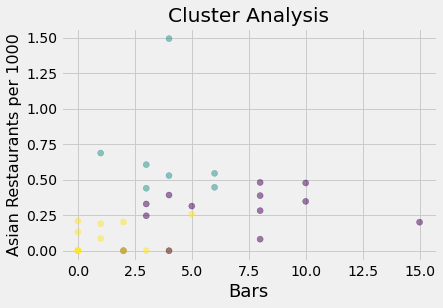

In [91]:
# clusters scatterplot bars x asian/1000

plt.scatter(X[:, 1], X[:, 2], c=labels.astype(np.float), alpha=0.5)
plt.title("Cluster Analysis")
plt.xlabel("Bars", fontsize=18)
plt.ylabel("Asian Restaurants per 1000", fontsize=16)

plt.show()

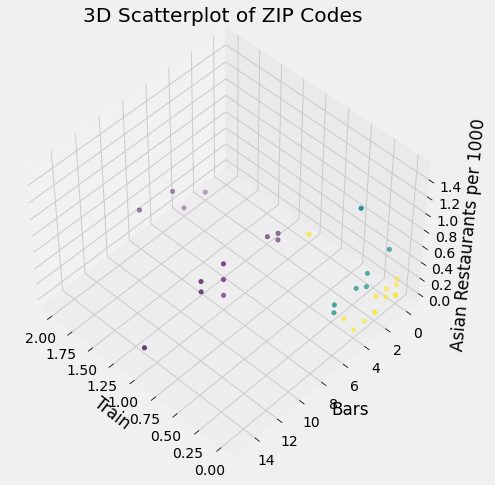

In [92]:
# plot the zips in three dimensions plus indicate cluster

fig = plt.figure(1, figsize=(8,6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_title("3D Scatterplot of ZIP Codes")
ax.set_xlabel("Train")
ax.set_ylabel("Bars")
ax.set_zlabel("Asian Restaurants per 1000")

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float)) 

Here's a list of the ZIP codes in each cluster:

In [95]:
print("CLUSTER 0")
for index, row in zip_data.iterrows():
    if (row["Cluster"] == 0):
        print(row[0], row[1])
    else:
        continue
print("-----")
print("CLUSTER 1")
for index, row in zip_data.iterrows():
    if (row["Cluster"] == 1):
        print(row[0], row[1])
    else:
        continue
print("-----")
print("CLUSTER 2")
for index, row in zip_data.iterrows():
    if (row["Cluster"] == 2):
        print(row[0], row[1])
    else:
        continue
print("-----")
print("CLUSTER 3")
for index, row in zip_data.iterrows():
    if (row["Cluster"] == 3):
        print(row[0], row[1])
    else:
        continue
print("-----")
print("CLUSTER 4")
for index, row in zip_data.iterrows():
    if (row["Cluster"] == 4):
        print(row[0], row[1])
    else:
        continue

CLUSTER 0
08009 Berlin
08026 Gibbsboro
08034 Cherry Hill
08045 Lawnside
08081 Sicklerville
08083 Somerdale
08109 Merchantville
-----
CLUSTER 1
08002 Cherry Hill
08003 Cherry Hill
08033 Haddonfield
08037 Hammonton
08102 Camden
08103 Camden
08104 Camden
08110 Pennsauken
-----
CLUSTER 2
08007 Barrington
08029 Glendora
08030 Gloucester City
08031 Bellmawr
08035 Haddon Heights
08049 Magnolia
08059 Mount Ephraim
08084 Stratford
08089 Waterford Works
08105 Camden
08106 Audubon
08107 Oaklyn
-----
CLUSTER 3
08004 Atco
08012 Blackwood
08021 Clementon
08043 Voorhees
08078 Runnemede
08080 Sewell
08108 Collingswood
-----
CLUSTER 4
08091 West Berlin


As mentioned above, I ran the model multiple times. Each time, I used a different number of centroids. 

After using the "elbow method", I found that the model with five centroids produced the best results. It yielded the following cluster, which only contained ZIP codes with superior attributes:

ZIP CODE | CITY
----- | -----
08004 | Atco
08012 | Blackwood
08021 | Clementon
08043 | Voorhees
08078 | Runnemede
08080 | Sewell
08108 | Collingswood

My next step was to prepare the ZIP codes in the top segment for further analysis. 

In [118]:
cluster_3_df

,ZIP Code,ZIP Code Name,Population,ZIP Type,Latitude,Longitude,Train,Bars,Nightlife,Asian,Japanese,Ramen,Sushi,Asian/1000pop,Cluster,Asian per 1000
1,08012,Blackwood,38992,Non-Unique,39.758867,-75.055420,1,8,11,11,2,0,1,0.282109,3,0.282109
2,08021,Clementon,44833,Non-Unique,39.802230,-75.019991,1,15,6,9,1,0,0,0.200745,3,0.200745
3,08043,Voorhees,29131,Non-Unique,39.849978,-74.952672,1,8,7,14,5,0,2,0.480588,3,0.480588
4,08078,Runnemede,8385,Non-Unique,39.851251,-75.072025,1,10,3,4,2,0,1,0.477042,3,0.477042
5,08080,Sewell,37433,Non-Unique,39.746545,-75.083831,1,10,9,13,5,0,2,0.347287,3,0.347287
6,08108,Collingswood,18045,Non-Unique,39.915604,-75.063271,2,8,6,7,4,0,4,0.387919,3,0.387919


I visually inspected the ZIP codes in the top segement and made two changes. First, I dropped Atco (08004) because it only had one Asian restaurant. Next, I checked the venue listings to make sure that the train stations in each ZIP code were PATCO Hi-Speedline stations, which were an important feature indicated by the client. As it turned out, only three of the ZIP codes in the top cluster had PATCO stations. The others had Conrail or other non-commuter rail facilities. After making these changes, three candidate ZIP codes remained:

ZIP Code | Name
----- | -----
08021 | Clementon
08043 | Voorhees
08108 | Collingswood

In [134]:
# filter out other clusters and visually inspect for outliers

is_cluster_3 = zip_data["Cluster"] == 3
cluster_3_df = zip_data[is_cluster_3]
cluster_3_df = cluster_3_df.reset_index()
cluster_3_df = cluster_3_df.drop(["index"], axis=1)
cluster_3_df

# drop Atco, which only has one Asian restaurant

cluster_3_df = cluster_3_df.drop([0], axis=0)
cluster_3_df

# drop cities that do not have PATCO train stations

zip_codes = cluster_3_df["ZIP Code"]
latitudes = cluster_3_df["Latitude"]
longitudes = cluster_3_df["Longitude"]

for zipc, lat, lng in zip(zip_codes, latitudes, longitudes):
    zip_code = zipc
    latitude = lat
    longitude = lng
    category_id = "4bf58dd8d48988d129951735"
    category_name = "Train Station"
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
    results = requests.get(url).json()  
    filtered_results = results["response"]["venues"]
    temp_train_df = pd.json_normalize(filtered_results)
    is_patco = temp_train_df["name"].str.contains("PATCO", regex=False)
    for item in is_patco:
        if item == True:
            print(f"PATCO Station found in {zip_code}.")
            break
        else:
            continue
        
final_df = cluster_3_df.drop([1, 4, 5], axis=0)
final_df

PATCO Station found in 08021.
PATCO Station found in 08043.
PATCO Station found in 08108.


,ZIP Code,ZIP Code Name,Population,ZIP Type,Latitude,Longitude,Train,Bars,Nightlife,Asian,Japanese,Ramen,Sushi,Asian/1000pop,Cluster,Asian per 1000
2,08021,Clementon,44833,Non-Unique,39.802230,-75.019991,1,15,6,9,1,0,0,0.200745,3,0.200745
3,08043,Voorhees,29131,Non-Unique,39.849978,-74.952672,1,8,7,14,5,0,2,0.480588,3,0.480588
6,08108,Collingswood,18045,Non-Unique,39.915604,-75.063271,2,8,6,7,4,0,4,0.387919,3,0.387919


### STEP SIX

The final task was to present the top three candidates and make a recommendation. I proceeded by making a new dataframe for each ZIP code, making an API call to get detailed venue information for it, and then created an interactive map with the venues plotted on it.  

In [137]:
# make map for Clementon, NJ 08021

# get train station information for 08021
zip_code = "08021"
latitude = 39.802230
longitude = -75.019991
category_id = "4bf58dd8d48988d129951735"
category_name = "Train Station"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
train_df = pd.json_normalize(filtered_results)
for index, row in train_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        train_df.drop([index], inplace=True)
    else:
        continue
count = len(train_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 
  
# get bar information for 08021  
category_id = "4bf58dd8d48988d116941735"
category_name = "Bar"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
bar_df = pd.json_normalize(filtered_results)
for index, row in bar_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        bar_df.drop([index], inplace=True)
    else:
        continue
count = len(bar_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 

# get asian restaurant info for 08021
category_id = "4bf58dd8d48988d142941735"
category_name = "Asian Restaurant"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
asian_df = pd.json_normalize(filtered_results)
for index, row in asian_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        asian_df.drop([index], inplace=True)
    else:
        continue
count = len(asian_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 

# make a map for 08021

zip_map = folium.Map(location=[latitude, longitude], zoom_start=13) #instantiate map
train_stations = folium.map.FeatureGroup() # create feature group for each venue type
bars = folium.map.FeatureGroup()
asians = folium.map.FeatureGroup()
for lat, lng in zip(train_df["location.lat"], train_df["location.lng"]): # plot train stations as blue
    train_stations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6)
        )
for lat, lng in zip(bar_df["location.lat"], bar_df["location.lng"]): # plot bars as yellow
    bars.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="yellow",
            fill_opacity=0.6)
        )
for lat, lng in zip(asian_df["location.lat"], asian_df["location.lng"]): # plot asian restaurants as red
    asians.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="red",
            fill_opacity=0.6)
        ) 

zip_map.add_child(train_stations) # add feature groups to map
zip_map.add_child(bars)
zip_map.add_child(asians)
zip_map

There are 1 Train Station(s) in 08021.
Train Station data stored for 08021.
There are 15 Bar(s) in 08021.
Bar data stored for 08021.
There are 9 Asian Restaurant(s) in 08021.
Asian Restaurant data stored for 08021.


In [138]:
# make map for Voorhees, NJ 08043

# get train station information for 08043
zip_code = "08043"
latitude = 39.849978
longitude = -74.952672
category_id = "4bf58dd8d48988d129951735"
category_name = "Train Station"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
train_df = pd.json_normalize(filtered_results)
for index, row in train_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        train_df.drop([index], inplace=True)
    else:
        continue
count = len(train_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 
  
# get bar information for 08043  
category_id = "4bf58dd8d48988d116941735"
category_name = "Bar"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
bar_df = pd.json_normalize(filtered_results)
for index, row in bar_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        bar_df.drop([index], inplace=True)
    else:
        continue
count = len(bar_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 

# get asian restaurant info for 08043
category_id = "4bf58dd8d48988d142941735"
category_name = "Asian Restaurant"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
asian_df = pd.json_normalize(filtered_results)
for index, row in asian_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        asian_df.drop([index], inplace=True)
    else:
        continue
count = len(asian_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 

# make a map for 08043

zip_map = folium.Map(location=[latitude, longitude], zoom_start=13) #instantiate map
train_stations = folium.map.FeatureGroup() # create feature group for each venue type
bars = folium.map.FeatureGroup()
asians = folium.map.FeatureGroup()
for lat, lng in zip(train_df["location.lat"], train_df["location.lng"]): # plot train stations as blue
    train_stations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6)
        )
for lat, lng in zip(bar_df["location.lat"], bar_df["location.lng"]): # plot bars as yellow
    bars.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="yellow",
            fill_opacity=0.6)
        )
for lat, lng in zip(asian_df["location.lat"], asian_df["location.lng"]): # plot asian restaurants as red
    asians.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="red",
            fill_opacity=0.6)
        ) 

zip_map.add_child(train_stations) # add feature groups to map
zip_map.add_child(bars)
zip_map.add_child(asians)
zip_map


There are 1 Train Station(s) in 08043.
Train Station data stored for 08043.
There are 8 Bar(s) in 08043.
Bar data stored for 08043.
There are 14 Asian Restaurant(s) in 08043.
Asian Restaurant data stored for 08043.


In [139]:
# make map for Collingswood, NJ 08108


# get train station information for 08108
zip_code = "08108"
latitude = 39.915604
longitude = -75.063271
category_id = "4bf58dd8d48988d129951735"
category_name = "Train Station"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
train_df = pd.json_normalize(filtered_results)
for index, row in train_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        train_df.drop([index], inplace=True)
    else:
        continue
count = len(train_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 
  
# get bar information for 08108  
category_id = "4bf58dd8d48988d116941735"
category_name = "Bar"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
bar_df = pd.json_normalize(filtered_results)
for index, row in bar_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        bar_df.drop([index], inplace=True)
    else:
        continue
count = len(bar_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 

# get asian restaurant info for 08108
category_id = "4bf58dd8d48988d142941735"
category_name = "Asian Restaurant"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, category_id, RADIUS, LIMIT)
results = requests.get(url).json()  
filtered_results = results["response"]["venues"]
asian_df = pd.json_normalize(filtered_results)
for index, row in asian_df.iterrows():
    if (row["location.postalCode"] != zip_code):
        asian_df.drop([index], inplace=True)
    else:
        continue
count = len(asian_df)
print(f"There are {count} {category_name}(s) in {zip_code}.")
print(f"{category_name} data stored for {zip_code}.") 

# make a map for 08108

zip_map = folium.Map(location=[latitude, longitude], zoom_start=13) #instantiate map
train_stations = folium.map.FeatureGroup() # create feature group for each venue type
bars = folium.map.FeatureGroup()
asians = folium.map.FeatureGroup()
for lat, lng in zip(train_df["location.lat"], train_df["location.lng"]): # plot train stations as blue
    train_stations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6)
        )
for lat, lng in zip(bar_df["location.lat"], bar_df["location.lng"]): # plot bars as yellow
    bars.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="yellow",
            fill_opacity=0.6)
        )
for lat, lng in zip(asian_df["location.lat"], asian_df["location.lng"]): # plot asian restaurants as red
    asians.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color="black",
            fill=True,
            fill_color="red",
            fill_opacity=0.6)
        ) 

zip_map.add_child(train_stations) # add feature groups to map
zip_map.add_child(bars)
zip_map.add_child(asians)
zip_map


There are 2 Train Station(s) in 08108.
Train Station data stored for 08108.
There are 8 Bar(s) in 08108.
Bar data stored for 08108.
There are 7 Asian Restaurant(s) in 08108.
Asian Restaurant data stored for 08108.


### DISCUSSION AND RECOMMENDATION

Among the three finalists, I recommend that the clients establish their izakaya in Collingswood, 08108. While all three have their merits, Collingswood is a superior location due to its concentration of desired venues in a small space. This section will provide a brief discussion of all three finalists.

#### CLEMENTON, 08021

In terms of population, the 08021 ZIP code is one of the largest in Camden County. Its location in the center of the county means that it is close to a majority of the county's population. Clementon has many of the features the investors are looking for, including a lively bar scene, Asian restaurants, and a PATCO Hi-Speedline station. One concern is that the bars and restaurants are a bit spread out, as shown on the map. Further, they are far from the train station, which indicates a location that is not walkable. While Clementon looks good in terms of the essential features, the distance of the PATCO from the bars and restaurants negates the value of the PATCO in the first place.

#### VOORHEES, 08043

Voorhees (08043) is a large ZIP code in eastern Camden County. A bit farther from Philadelphia that the other finalists, Voorhees still has an impressive set of essential features. Like Clementon, however, its PATCO station (indicated in blue) is situated on one end of the ZIP code. Voorhees's fourteen Asian restaurants (indicated in red) are impressive, but are distributed throughout the area. A greater concentration in closer proximity to the PATCO station would be better.

#### COLLINGSWOOD, 08108

Among the three finalists, Collingswood is the smallest in terms of population and area. It is also the closest to Philadelphia and it has two PATCO stations, one on each end of Haddon Avenue. Haddon Avenue is known locally as "restaurant row" and is home to award-winning restaurants. The western end of Haddon Avenue is "dry" by local ordinance, meaning that alcohol can be consumed but not purchased there. The eastern end of Haddon Avenue, still walkable to both PATCO stations, has an assortment of bars and nightlife spots. It is here that an izakaya would be most appropriate. 

For these reasons, I concluded that Collingswood (08108) is the best place for the client to establish a new izakaya. Any of the three ZIP codes presented, however, would be suitable based on the investors' preferences.